In [1]:
import torch
import random
from resnet import ResNet18
from preact_resnet import PreActResNet, Swish, CIFAR10_MEAN, CIFAR10_MEAN, CIFAR10_STD
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from advertorch.attacks import LinfPGDAttack
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sns.color_palette("tab10")
from collections import defaultdict
# some setting
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.backends.cudnn.benchmark = True

transform_test = transforms.Compose([
    transforms.ToTensor(),
])
transform_resize = transforms.Compose([
    transforms.Resize(32),
    transforms.Grayscale(3),
    transforms.ToTensor(),
])

test_c10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
loader_c10 = torch.utils.data.DataLoader(test_c10, batch_size=200, shuffle=False, num_workers=8)


def return_model(checkpoint_name, preact=False):
    if not preact:
        net = ResNet18()
        net = net.cuda()
        net = torch.nn.DataParallel(net)
        checkpoint = torch.load(checkpoint_name)
        net.load_state_dict(checkpoint['net'])
    else:
        net = PreActResNet(num_classes=10, depth=18, width=0,
        activation_fn=Swish, mean=CIFAR10_MEAN,
        std=CIFAR10_STD)
        checkpoint = torch.load(checkpoint_name)
        net.load_state_dict(checkpoint)
        net = net.cuda()
    net.eval()
    return net


def adversarial_eval(model, test_loader):
    begin = time.time()
    print('\n PGD ATTACK Start')
    criterion = nn.CrossEntropyLoss()
    adversary = LinfPGDAttack(model, loss_fn=criterion, eps=0.0314, nb_iter=7, eps_iter=0.00784, rand_init=True, clip_min=0.0, clip_max=1.0, targeted=False)
    benign_loss = 0
    adv_loss = 0
    benign_correct = 0
    adv_correct = 0
    total = 0
    clean_logits = []
    adv_logits = []
    labels = []
    for batch_idx, (inputs, targets) in tqdm(enumerate(test_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            total += targets.size(0)
            labels.append(targets)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            benign_loss += loss.item()

            _, predicted = outputs.detach().max(1)
            clean_logits.append(outputs.detach())
            benign_correct += predicted.eq(targets).sum().item()

        adv = adversary.perturb(inputs, targets)
        adv_outputs = model(adv)
        adv_logits.append(adv_outputs.detach())
        loss = criterion(adv_outputs, targets)
        adv_loss += loss.item()

        _, predicted = adv_outputs.detach().max(1)
        adv_correct += predicted.eq(targets).sum().item()
    benign_acc = benign_correct / total
    adv_acc = adv_correct / total
    dura = time.time() - begin
    print(f'Adversarial evaluation time: {dura:.5}s')
    clean_logits = torch.stack(clean_logits, dim=0).view(-1, clean_logits[0].shape[-1])
    adv_logits = torch.stack(adv_logits, dim=0).view(-1, adv_logits[0].shape[-1])
    labels = torch.stack(labels, dim=0).view(-1)
    return clean_logits, adv_logits, labels, benign_acc, adv_acc


Files already downloaded and verified


In [ ]:
vanilla_net = return_model('PGD_AT/basic_training', preact=False)
pgd_net = return_model('PGD_AT/pgd_adversarial_training', preact=False)
augment_net = return_model('AUGMENT_AT/ddpm.pt', preact=True)

In [3]:
# Evaluating adversarial robustness
van_clean_logits, van_adv_logits, labels, van_benign_acc, van_adv_acc = adversarial_eval(vanilla_net, loader_c10)
pgd_clean_logits, pgd_adv_logits, _, pgd_benign_acc, pgd_adv_acc = adversarial_eval(pgd_net, loader_c10)
aug_clean_logits, aug_adv_logits, _, aug_benign_acc, aug_adv_acc = adversarial_eval(augment_net, loader_c10)


 PGD ATTACK Start


50it [03:33,  4.28s/it]

Adversarial evaluation time: 213.98s

 PGD ATTACK Start



50it [03:34,  4.29s/it]

Adversarial evaluation time: 214.7s

 PGD ATTACK Start



50it [05:31,  6.64s/it]

Adversarial evaluation time: 332.03s


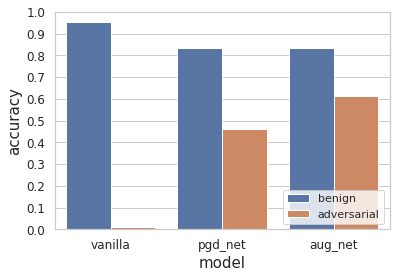

In [5]:
# visualizing adversarial and robust accuracy
plt.figure(figsize = (6,4))
benign_adv_dict = dict()
benign_adv_dict['evaluation'] = ['benign', 'adversarial']*3
benign_adv_dict['model'] = ['vanilla']*2 + ['pgd_net']*2 + ['aug_net'] *2
benign_adv_dict['acc'] = [van_benign_acc, van_adv_acc, pgd_benign_acc, pgd_adv_acc, aug_benign_acc, aug_adv_acc]
benign_adv_df = pd.DataFrame(benign_adv_dict)
ax = sns.barplot(data=benign_adv_df, x='model', y='acc', hue='evaluation')
_ = ax.set_yticks(np.linspace(0, 1.0, 11))
ax.tick_params(axis='both', labelsize=12)
_ = ax.set_xlabel('model', fontsize=15)
_ = ax.set_ylabel('accuracy', fontsize=15)
_ = ax.legend(loc='lower right')

In [6]:
# Uncertainty calibration
class ECELoss(nn.Module):
    '''
    Compute ECE (Expected Calibration Error)
    '''
    def __init__(self, n_bins=15):
        super(ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        if len(labels.shape) != 1:
            labels = labels.view(-1)
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece
static_ece = ECELoss(100).to(device)

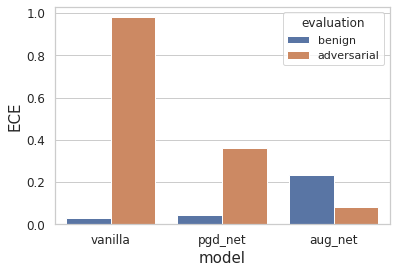

In [7]:
# Uncertainty evaluation
plt.figure(figsize = (6,4))
benign_adv_df['ece'] = [
    static_ece(van_clean_logits, labels).item(),
    static_ece(van_adv_logits, labels).item(),
    static_ece(pgd_clean_logits, labels).item(),
    static_ece(pgd_adv_logits, labels).item(),
    static_ece(aug_clean_logits, labels).item(),
    static_ece(aug_adv_logits, labels).item()
]
ax = sns.barplot(data=benign_adv_df, x='model', y='ece', hue='evaluation')
# _ = ax.set_yticks(np.linspace(0, 1.0, 11))
ax.tick_params(axis='both', labelsize=12)
_ = ax.set_xlabel('model', fontsize=15)
_ = ax.set_ylabel('ECE', fontsize=15)

In [8]:
## OOD detection

from sklearn import metrics

svhn_dataset = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_test)
svhn_loader = torch.utils.data.DataLoader(svhn_dataset, batch_size=256, shuffle=False, num_workers=8)


kmnist_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform_resize)
kmnist_loader = torch.utils.data.DataLoader(kmnist_dataset, batch_size=256, shuffle=False, num_workers=8)

def entropy(net_output):
    p = F.softmax(net_output, dim=1)
    logp = F.log_softmax(net_output, dim=1)
    plogp = p * logp
    entropy = - torch.sum(plogp, dim=1)
    return entropy

def confidence(net_output):
    p = F.softmax(net_output, dim=1)
    confidence, _ = torch.max(p, dim=1)
    return confidence


def get_auc(net, logits, labels, ood_test_loader, device):
    bin_labels_entropies = None
    bin_labels_confidences = None
    entropies = None
    confidences = None
    print('Evaluating OOD detection')
    net.eval()
    with torch.no_grad():
        # Getting entropies for in-distribution data

        bin_labels_entropies = torch.zeros(labels.shape).to(device)
#         bin_labels_confidences = torch.ones(labels.shape).to(device)

        entropies = entropy(logits)
#         confidences = confidence(logits)

        # Getting entropies for OOD data
        for i, (data, label) in enumerate(ood_test_loader):
            data = data.to(device)
            label = label.to(device)

            bin_label_entropy = torch.ones(label.shape).to(device)
#             bin_label_confidence = torch.zeros(label.shape).to(device)

            net_output = net(data)
            entrop = entropy(net_output)
#             conf = confidence(net_output)

            bin_labels_entropies = torch.cat((bin_labels_entropies, bin_label_entropy))
#             bin_labels_confidences = torch.cat((bin_labels_confidences, bin_label_confidence))
            entropies = torch.cat((entropies, entrop))
#             confidences = torch.cat((confidences, conf))
            
#     auc_confidence = metrics.roc_auc_score(bin_labels_confidences.cpu().numpy(), confidences.cpu().numpy())
    auc_entropy = metrics.roc_auc_score(bin_labels_entropies.cpu().numpy(), entropies.cpu().numpy())
    print('Evaluation completed')
    
#     return auc_confidence, auc_entropy
    return auc_entropy

Using downloaded and verified file: ./data/test_32x32.mat


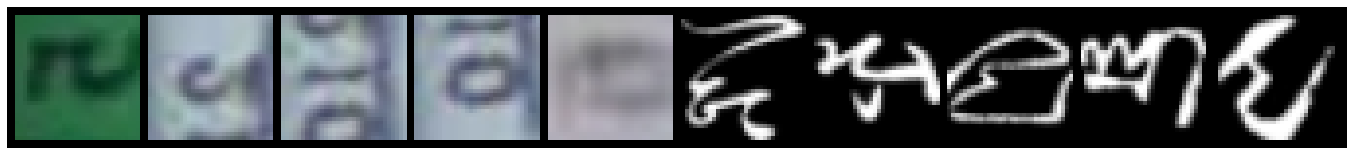

In [9]:
# ploting SVHN and KMNIST samples
ood_sample_list = []
for loader in [svhn_loader, kmnist_loader]:
    for batch, _ in loader:
        samples = [i.squeeze() for i in batch[:5].split(1)]
        ood_sample_list.extend(samples)
        break
_ = plt.figure(figsize=(24,10))
plt.grid(False)
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(ood_sample_list, nrow=1).permute(2,1,0))
plt.show()

In [10]:
# evaluating OOD detection on two OOD datasets for three models (vanilla, pgd_net and aug_net)
aucs = []
aucs.append(get_auc(vanilla_net, van_clean_logits, labels, svhn_loader, device))
aucs.append(get_auc(pgd_net, pgd_clean_logits, labels, svhn_loader, device))
aucs.append(get_auc(augment_net, aug_clean_logits, labels, svhn_loader, device))
aucs.append(get_auc(vanilla_net, van_clean_logits, labels, kmnist_loader, device))
aucs.append(get_auc(pgd_net, pgd_clean_logits, labels, kmnist_loader, device))
aucs.append(get_auc(augment_net, aug_clean_logits, labels, kmnist_loader, device))


Evaluating OOD detection
Evaluation completed
Evaluating OOD detection
Evaluation completed
Evaluating OOD detection
Evaluation completed
Evaluating OOD detection
Evaluation completed
Evaluating OOD detection
Evaluation completed
Evaluating OOD detection
Evaluation completed


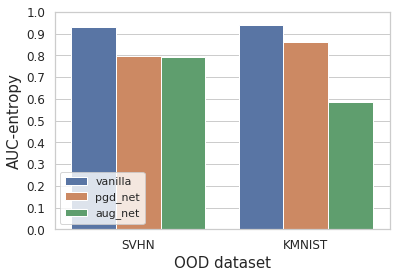

In [11]:
# visualizing AUCs of the OOD detection
plt.figure(figsize = (6,4))
ood_dict = dict()
ood_dict['ood_data'] = ['SVHN', 'KMNIST']*3
ood_dict['model'] = ['vanilla','pgd_net','aug_net'] * 2
ood_dict['auc'] = aucs
ood_df = pd.DataFrame(ood_dict)
ax = sns.barplot(data=ood_df, x='ood_data', y='auc', hue='model')
_ = ax.set_yticks(np.linspace(0, 1.0, 11))
ax.tick_params(axis='both', labelsize=12)
_ = ax.set_xlabel('OOD dataset', fontsize=15)
_ = ax.set_ylabel('AUC-entropy', fontsize=15)
_ = ax.legend(loc='lower left')

In [12]:
# Robustness under distributional shift
CORRUPTIONS_LIST = ['brightness', 'gaussian_blur', 'motion_blur', 'spatter',
                  'contrast', 'gaussian_noise', 'pixelate', 'speckle_noise',
                  'defocus_blur', 'glass_blur', 'zoom_blur', 'elastic_transform',
                  'impulse_noise', 'saturate', 'fog', 'jpeg_compression',
                  'shot_noise', 'frost', 'snow']
from torch.utils.data import Dataset
import numpy as np


class CorruptionDatasetGenerator(Dataset):

    def __init__(self, ds_dir, intensity, corruption):
        data = np.load(ds_dir + corruption + '.npy')[10000 * intensity : 10000 * (intensity + 1)]
        labels = np.load(ds_dir + 'labels.npy')[10000 * intensity : 10000 * (intensity + 1)]
        assert data.shape[0] == labels.shape[0]
        self.data = data
        self.targets = list(labels.astype(np.int_))
        self.transform = transform_test

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.transform(self.data[i]), self.targets[i]
    
def generate_multi_loaders(ds_dir, intensities, corr_list):
    loaders = []
    assert len(intensities) and len(corr_list)
    for corr in corr_list:
        for intensity in intensities:
            assert intensity in range(5)
            new_ds = CorruptionDatasetGenerator(ds_dir, intensity, corr)
            loader = torch.utils.data.DataLoader(new_ds, batch_size=500, shuffle=False, num_workers=8)
            loaders.append(loader)
    return loaders

def normal_eval(model, test_loader):
    begin = time.time()
    criterion = nn.CrossEntropyLoss()
    corrects = 0
    total = 0
    logits = []
    labels = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            total += targets.size(0)
            labels.append(targets)
            outputs = model(inputs)

            _, predicted = outputs.detach().max(1)
            logits.append(outputs.detach())
            corrects += predicted.eq(targets).sum().item()
#         print(f'\nTotal dataset shift test accuarcy: {100. * corrects / total:.5}%')
#         dura = time.time() - begin
#         print(f'Total adversarial test time: {dura}s')
        logits = torch.stack(logits, dim=0).view(-1, logits[0].shape[-1])
        labels = torch.stack(labels, dim=0).view(-1)
    return logits, labels, corrects / total


In [13]:
# evaluating DNNs on CIFAR10-C
log_dict = defaultdict(list)

def corr_eval(model, model_name, corruptions_list):
    for corruption in tqdm(corruptions_list):
        loaders = generate_multi_loaders('data/CIFAR-10-C/', range(5), [corruption])
        for severity, loader in enumerate(loaders):
            logits, labels, acc = normal_eval(model, loader)
            ece = static_ece(logits, labels).item()
            log_dict['corruption'].append(corruption)
            log_dict['severity'].append(severity)
            log_dict['acc'].append(acc)
            log_dict['ece'].append(ece)
            log_dict['model'].append(model_name)

corr_eval(vanilla_net, 'vanilla', CORRUPTIONS_LIST)
corr_eval(pgd_net, 'pgd_net', CORRUPTIONS_LIST)
corr_eval(augment_net, 'aug_net', CORRUPTIONS_LIST)

100%|██████████| 19/19 [19:56<00:00, 62.97s/it]


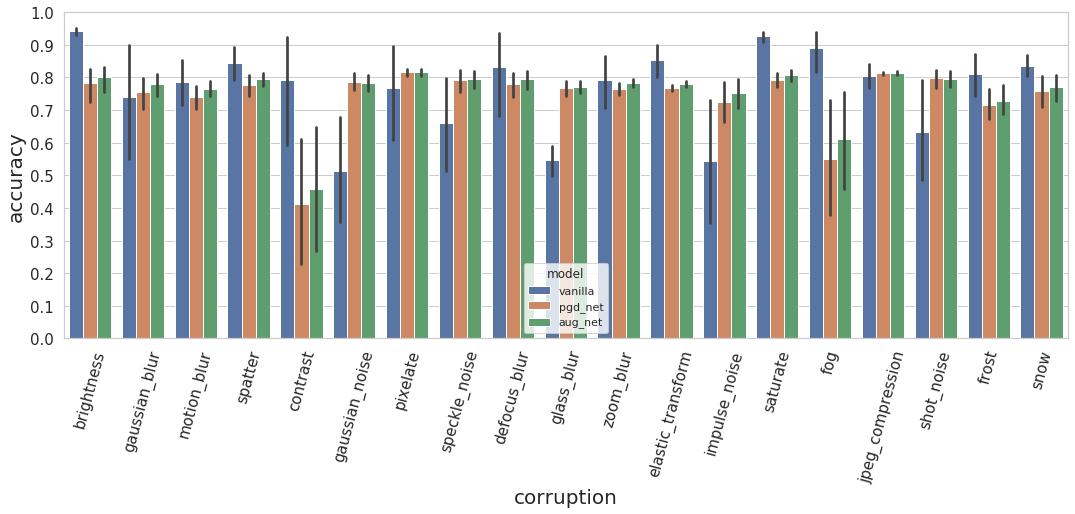

In [14]:
# visualizing accuracy on different corruptions
df = pd.DataFrame(data=log_dict)
plt.figure(figsize = (18,6))
ax = sns.barplot(data=df, x='corruption', y='acc', hue='model')
_ = ax.set_yticks(np.linspace(0, 1.0, 11))
_ = ax.set_xticklabels(CORRUPTIONS_LIST, rotation=75)
ax.tick_params(axis='both', labelsize=15)
_ = ax.set_xlabel('corruption', fontsize=20)
_ = ax.set_ylabel('accuracy', fontsize=20)

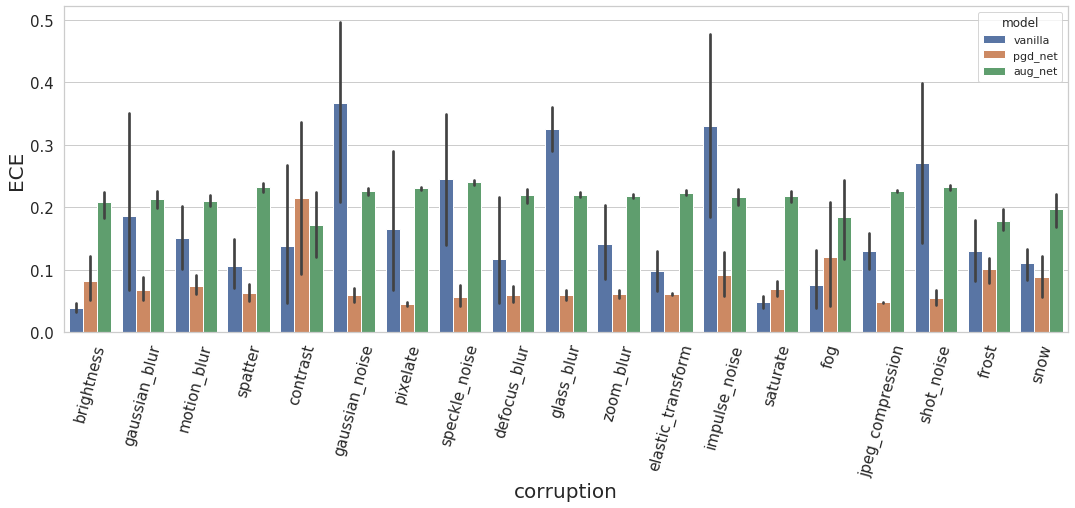

In [15]:
plt.figure(figsize = (18,6))
ax = sns.barplot(data=df, x='corruption', y='ece', hue='model')
ax.tick_params(axis='both', labelsize=15)
_ = ax.set_xticklabels(CORRUPTIONS_LIST, rotation=75)
_ = ax.set_xlabel('corruption', fontsize=20)
_ = ax.set_ylabel('ECE', fontsize=20)

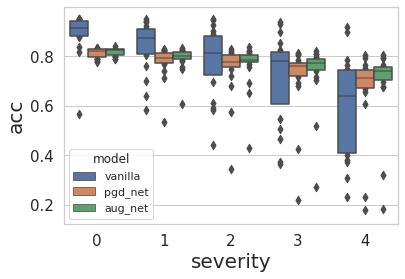

In [19]:
# visualizing accuracy at different severities
plt.figure(figsize = (6,4))
ax = sns.boxenplot(data=df, x='severity', y='acc', hue='model')
ax.tick_params(axis='both', labelsize=15)
_ = ax.set_xlabel('severity', fontsize=20)
_ = ax.set_ylabel('acc', fontsize=20)

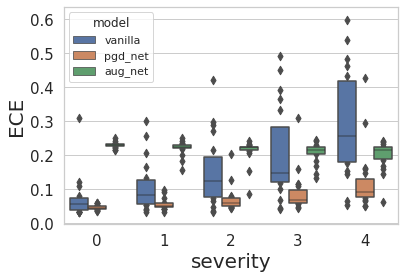

In [20]:
# visualizing ECE at different severities
plt.figure(figsize = (6,4))
ax = sns.boxenplot(data=df, x='severity', y='ece', hue='model')
ax.tick_params(axis='both', labelsize=15)
_ = ax.set_xlabel('severity', fontsize=20)
_ = ax.set_ylabel('ECE', fontsize=20)

In [21]:
# Rotational invariance
# prepare custom transforms
import torchvision.transforms.functional as TF
import random


class FixRotationTF:
    """Rotate by the given angle."""

    def __init__(self, angle):
        self.angle = angle

    def __call__(self, x):
        return TF.rotate(x, self.angle)

rotation_TF_list = [FixRotationTF(i) for i in range(0,195,15)]

In [22]:
# prepare datasets and dataloaders
transform_rotation_list = [transforms.Compose([i,transforms.ToTensor()])
                           for i in rotation_TF_list]
rotation_ds_list = [torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=i)
                    for i in transform_rotation_list]
loaders_rotation_c10 = [torch.utils.data.DataLoader(i, batch_size=500, shuffle=False, num_workers=8)
                        for i in rotation_ds_list]

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


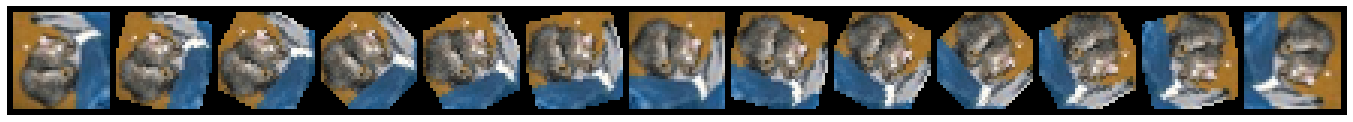

In [23]:
# examples of different angles of rotation
example_list = []
for loader in loaders_rotation_c10:
    for batch, _ in loader:
        example_list.append(batch[0])
        break

_ = plt.figure(figsize=(24,10))
plt.grid(False)
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(example_list, nrow=1).permute(2,1,0))
plt.show()

In [24]:
# evaluating rotational invariance

rotation_log_dict = defaultdict(list)

def rotation_eval(model, model_name):
    for rotation, loader in enumerate(loaders_rotation_c10):
        begin = time.time()
        logits, labels, acc = normal_eval(model, loader)
        ece = static_ece(logits, labels).item()
        rotation_log_dict['angle'].append(rotation*15)
        rotation_log_dict['acc'].append(acc)
        rotation_log_dict['ece'].append(ece)
        rotation_log_dict['model'].append(model_name)
        print(f'Evaluate {model_name} on C10 with rotation of {rotation*15} degrees in {time.time()-begin:.5} s')

rotation_eval(vanilla_net, 'vanilla')
rotation_eval(pgd_net, 'pgd_net')
rotation_eval(augment_net, 'aug_net')

Evaluate vanilla on C10 with rotation of 0 degrees in 8.5382 s
Evaluate vanilla on C10 with rotation of 15 degrees in 8.213 s
Evaluate vanilla on C10 with rotation of 30 degrees in 8.9458 s
Evaluate vanilla on C10 with rotation of 45 degrees in 9.775 s
Evaluate vanilla on C10 with rotation of 60 degrees in 8.3581 s
Evaluate vanilla on C10 with rotation of 75 degrees in 8.7134 s
Evaluate vanilla on C10 with rotation of 90 degrees in 8.3544 s
Evaluate vanilla on C10 with rotation of 105 degrees in 8.5277 s
Evaluate vanilla on C10 with rotation of 120 degrees in 8.7534 s
Evaluate vanilla on C10 with rotation of 135 degrees in 8.2615 s
Evaluate vanilla on C10 with rotation of 150 degrees in 8.2188 s
Evaluate vanilla on C10 with rotation of 165 degrees in 8.2431 s
Evaluate vanilla on C10 with rotation of 180 degrees in 8.1942 s
Evaluate pgd_net on C10 with rotation of 0 degrees in 8.2054 s
Evaluate pgd_net on C10 with rotation of 15 degrees in 8.2352 s
Evaluate pgd_net on C10 with rotation 

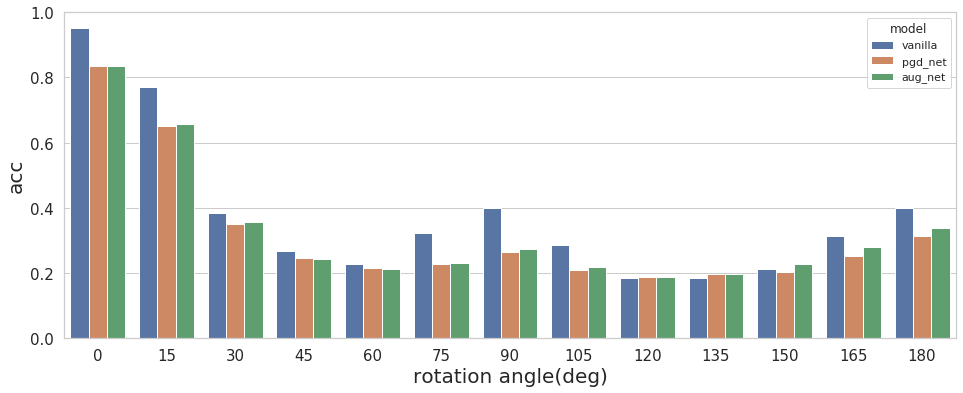

In [25]:
# visualizing accuracy
df_rotation = pd.DataFrame(rotation_log_dict)
plt.figure(figsize = (16,6))
ax = sns.barplot(data=df_rotation, x='angle', y='acc', hue='model')
ax.tick_params(axis='both', labelsize=15)
_ = ax.set_xlabel('rotation angle(deg)', fontsize=20)
_ = ax.set_ylabel('acc', fontsize=20)

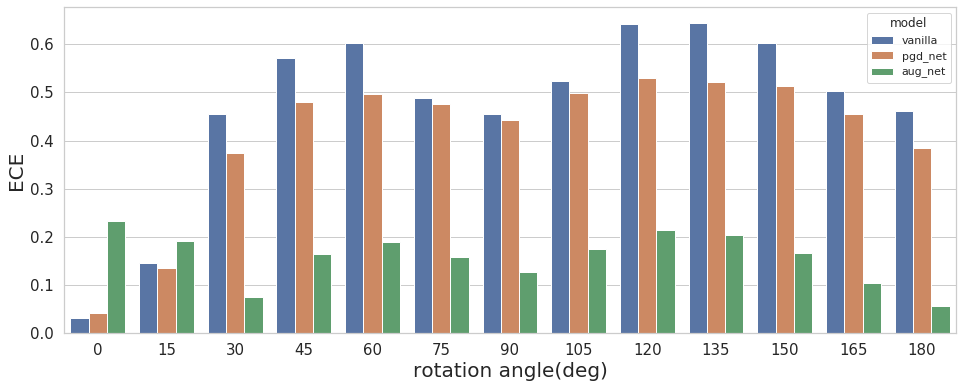

In [26]:
# visualizing ECE
plt.figure(figsize = (16,6))
ax = sns.barplot(data=df_rotation, x='angle', y='ece', hue='model')
ax.tick_params(axis='both', labelsize=15)
_ = ax.set_xlabel('rotation angle(deg)', fontsize=20)
_ = ax.set_ylabel('ECE', fontsize=20)